# Using a seq2seq LSTM to forecast sales from the Walmart Kaggle data set 

First pass at using an LSTM to forecast the sales from the [Walmart store-department sales data set](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). 

This notbook was run on a GCP Jupyterlab instance with TensorFlow:1.13 installed and 16 vCPUs, 60 GB RAM 

The notebook is organized as follows: 

**1. Loading and Cleaning the Data**   
**2. Formatting the Data for Modeling**  
**3. Building the Model - Training Architecture**  
**4. Building the Model - Inference Architecture**  
**5. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [6]:
df = pd.read_csv('train.csv')
df['Dept'] = df['Dept'].astype(str)
df['Store'] = df['Store'].astype(str)
df['Dept-Store'] = df[['Dept', 'Store']].apply(lambda x: '-'.join(x), axis=1)
df = df[['Dept-Store', 'Date','Weekly_Sales']]
df.head(5)

,Dept-Store,Date,Weekly_Sales
0,1-1,2010-02-05,24924.50
1,1-1,2010-02-12,46039.49
2,1-1,2010-02-19,41595.55
3,1-1,2010-02-26,19403.54
4,1-1,2010-03-05,21827.90


Now note that there are some negative sales values (returns? Shrinkage?) for this first pass, we will just set them all to zero

In [7]:
df[(df['Weekly_Sales'] < 0)].head()

,Dept-Store,Date,Weekly_Sales
846,6-1,2012-08-10,-139.65
2384,18-1,2012-05-04,-1.27
6048,47-1,2010-02-19,-863.00
6049,47-1,2010-03-12,-698.00
6051,47-1,2010-10-08,-58.00


In [8]:
df['Weekly_Sales'] = df['Weekly_Sales'].clip(lower = 0)

Now we're going to pivot the table so as to make the data more sequential for our LSTM model 

In [9]:
df = df.pivot(index='Dept-Store',columns='Date', values='Weekly_Sales')
df = df.reset_index()
df.head(5)

Date,Dept-Store,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,...,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26
0,1-1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,...,16286.40,16680.24,18322.37,19616.22,19251.50,18947.81,21904.47,22764.01,24185.27,27390.81
1,1-10,40212.84,67699.32,49748.33,33601.22,36572.44,36380.70,38252.33,51956.73,131853.01,...,26804.84,26083.28,29426.33,30321.06,30872.22,31477.50,36323.95,40626.47,44224.36,58409.83
2,1-11,19611.13,39996.04,25294.18,14342.11,16181.87,17196.89,17434.44,19715.75,54900.47,...,14534.12,14363.58,15598.79,16399.69,18095.88,17297.21,20921.13,22563.76,22821.58,23746.39
3,1-12,17426.75,37734.82,22135.29,14942.21,17098.49,15535.51,15038.34,17477.41,43175.19,...,12074.69,12377.76,14482.94,13305.60,13090.69,14074.26,16263.81,18127.42,19839.67,25883.95
4,1-13,46761.90,78415.94,44042.19,31574.04,34505.07,41709.47,49711.13,60176.08,139870.90,...,34554.33,36004.03,35489.42,37693.05,37857.40,36678.66,44180.86,47496.96,59197.86,73165.41


For certain department stores, if there were no sales for a specific date, then there was no line at all in the CSV file. Once we pivot the dataframe, this creates a whole bunch of 'NA' values for the missing dates. We will assume that those are zero sales and fill them out with '0s'

In [7]:
df = df.fillna(0)

In [11]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2010-02-05 to 2012-10-26


We can visualize some of these series. For the sake of smoothing out the scale of sales units across different stores and different departments, we apply a log transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series. We will do this again later when feeding the data to our neural network.

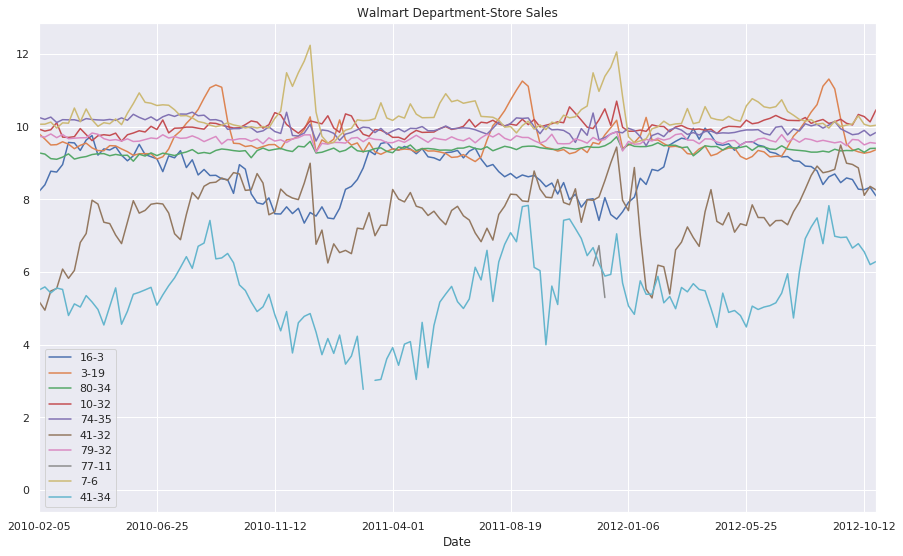

In [13]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Dept-Store'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(15,9))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Walmart Department-Store Sales')
    plt.legend(page_labels)
    
plot_random_series(df, 10)

## 2. Formatting the Data for seq2seq Modeling 

Now we need to split the data into train and test sets. This is a little bit tricky since were turing time seris sales data into a seq2seq supervised learning problem

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 12 Weeks)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 12 Weeks)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [15]:
from datetime import timedelta

pred_steps = 12
pred_length=timedelta(weeks=pred_steps)

In [16]:
pred_length

datetime.timedelta(84)

In [17]:
first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)
print(first_day, ',' , last_day)

2010-02-05 00:00:00 , 2012-10-26 00:00:00


In [18]:
val_pred_start = last_day - pred_length + timedelta(weeks = 1)
val_pred_end = last_day
print(val_pred_start,',',val_pred_end)

2012-08-10 00:00:00 , 2012-10-26 00:00:00


In [19]:
train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(weeks=1) 
print(train_pred_start,',',train_pred_end)

2012-05-18 00:00:00 , 2012-08-03 00:00:00


In [20]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(weeks = 1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(weeks = 1) 

In [22]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nTotal Series lenght',int((last_day - first_day).days/7))
print('Encoding interval:', int(enc_length.days/7))
print('Prediction interval:', int(pred_length.days/7))

Train encoding: 2010-02-05 00:00:00 - 2012-05-11 00:00:00
Train prediction: 2012-05-18 00:00:00 - 2012-08-03 00:00:00 

Val encoding: 2010-04-30 00:00:00 - 2012-08-03 00:00:00
Val prediction: 2012-08-10 00:00:00 - 2012-10-26 00:00:00

Total Series lenght 142
Encoding interval: 119
Prediction interval: 12


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 

In [29]:
date_to_index.head()

2010-02-05    0
2010-02-12    1
2010-02-19    2
2010-02-26    3
2010-03-05    4
dtype: int64

In [38]:
series_array

array([[2.492450e+04, 4.603949e+04, 4.159555e+04, ..., 2.276401e+04,
        2.418527e+04, 2.739081e+04],
       [4.021284e+04, 6.769932e+04, 4.974833e+04, ..., 4.062647e+04,
        4.422436e+04, 5.840983e+04],
       [1.961113e+04, 3.999604e+04, 2.529418e+04, ..., 2.256376e+04,
        2.282158e+04, 2.374639e+04],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 6.500000e+01,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 5.002000e+01,
        3.000000e-02, 1.000000e-02]])

In [41]:
inds = date_to_index['2010-02-05':'2010-03-05']
series_array[:,inds][:3]

array([[24924.5 , 46039.49, 41595.55, 19403.54, 21827.9 ],
       [40212.84, 67699.32, 49748.33, 33601.22, 36572.44],
       [19611.13, 39996.04, 25294.18, 14342.11, 16181.87]])

In [39]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])
series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## 3. Building the Model - Training Architecture

This architecture / code is adapted from the excellent [keras blog introduction to seq2seq](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html). Chollet's piece shows the more classic seq2seq application to machine translation, but the steps we need to take here are very similar.

Note that we'll use **teacher forcing**, where during training, the true series values (lagged by one time step) are fed as inputs to the decoder. Intuitively, we are trying to teach the NN how to condition on previous time steps to predict the next. At prediction time, the true values in this process will be replaced by predicted values for each previous time step.

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [2]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [3]:
model.save('keras.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


With our training architecture defined, we're ready to train the model! This will take some time if you're not running fancy hardware (read GPU). We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss. 

For better results, you could try using more data, adjusting the hyperparameters, tuning the learning rate and number of epochs, etc.  

In [43]:
first_n_samples = 1000
batch_size = 10
epochs = 1000

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]

In [44]:
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

In [45]:
# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [46]:
# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [ ]:
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 27s 34ms/step - loss: 0.4188 - val_loss: 0.2109
Epoch 2/1000
800/800 [==============================] - 22s 27ms/step - loss: 0.2363 - val_loss: 0.1973
Epoch 3/1000
800/800 [==============================] - 22s 27ms/step - loss: 0.2428 - val_loss: 0.2020
Epoch 4/1000
800/800 [==============================] - 22s 27ms/step - loss: 0.2266 - val_loss: 0.1884
Epoch 5/1000
800/800 [==============================] - 22s 27ms/step - loss: 0.2202 - val_loss: 0.1812
Epoch 6/1000
800/800 [==============================] - 21s 26ms/step - loss: 0.2179 - val_loss: 0.1862
Epoch 7/1000
800/800 [==============================] - 20s 26ms/step - loss: 0.2056 - val_loss: 0.1957
Epoch 8/1000
800/800 [==============================] - 21s 26ms/step - loss: 0.2099 - val_loss: 0.1828
Epoch 9/1000
800/800 [==============================] - 20s 25ms/step - lo

It's typically a good idea to look at the convergence curve of train/validation loss.

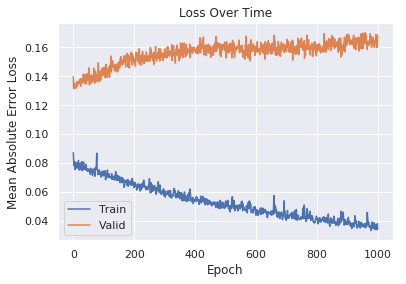

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

## 4. Building the Model - Inference Architecture

Not done with architecture yet! We need to use keras to define an inference model that draws on our neural network to actually generate predictions. In a nutshell, this architecture starts by encoding the input series, then generates predictions one by one. The decoder gets fed initial state vectors from the encoder, but the state vectors are then iteratively updated as the decoder generates a prediction for each time step.   

In [97]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

## 5. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder/target series pairs that we didn't train on. We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [98]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [99]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions manage to effectively anticipate some trends in the data and can understand when certain patterns should remain fairly steady. 

However, our predictions look overly conservative and clearly fail to capture a lot of the choppy variability in the data. We would likely stand to gain from increasing the sample size for training, tuning the network architecture/hyperparameters, and training for more epochs.  

**Check out the next notebook in this series** for fancier architectures and more expressive predictions.  

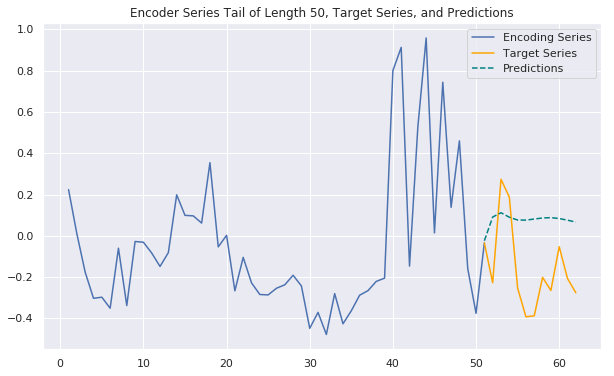

In [100]:
predict_and_plot(encoder_input_data, decoder_target_data, 100)

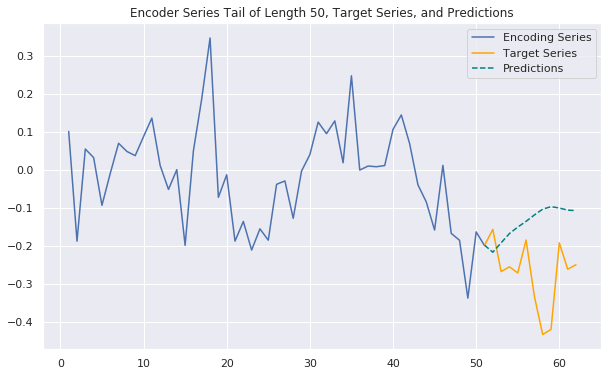

In [102]:
predict_and_plot(encoder_input_data, decoder_target_data, 50)

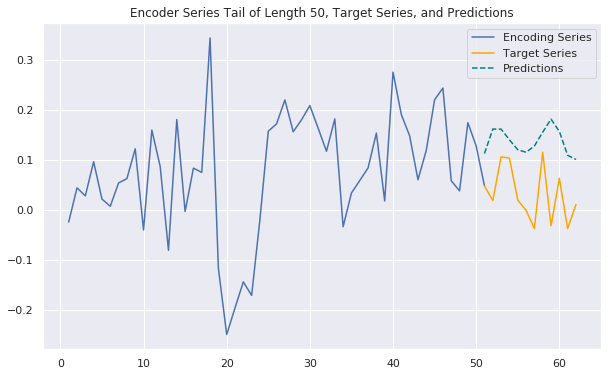

In [103]:
predict_and_plot(encoder_input_data, decoder_target_data, 78)

In [104]:
df[(df['Dept-Store']=='41-34')]

Date,Dept-Store,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05,2010-03-12,2010-03-19,2010-03-26,2010-04-02,...,2012-08-24,2012-08-31,2012-09-07,2012-09-14,2012-09-21,2012-09-28,2012-10-05,2012-10-12,2012-10-19,2012-10-26
1455,41-34,245.0,267.0,226.0,259.0,249.0,121.0,167.0,153.0,210.0,...,879.94,2507.35,1079.47,1042.65,1054.44,778.95,880.23,703.54,493.91,537.46


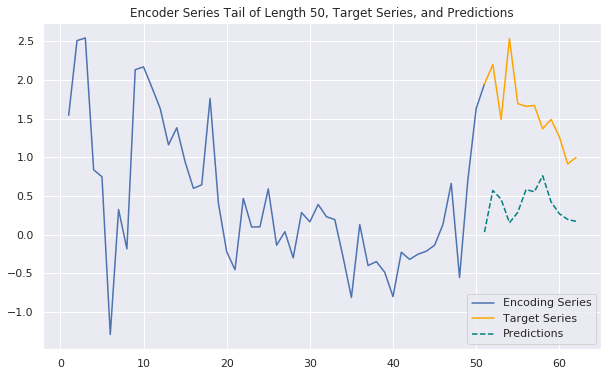

In [105]:
predict_and_plot(encoder_input_data, decoder_target_data, 1455)